In [88]:
pip install yfinance


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [89]:
import yfinance as yf
import pandas as pd

# Symbol en interval instellen
symbol = "GC=F"
interval = '5m'

# Download data voor de laatste 60 dagen
print("Download XAU/USD intraday data...")
xauusd_data = yf.download(symbol, period='60d', interval=interval)

# Controleer of er data is gedownload
if xauusd_data.empty:
    print("Geen data gevonden. Controleer het symbool of probeer een ander interval.")
else:
    # Toon de eerste paar rijen van de data
    print("Eerste paar rijen van de XAU/USD data (5 minuten):")
    print(xauusd_data.head())

    # Opslaan naar CSV-bestand
    file_name = "xauusd_intraday_5m_data.csv"
    xauusd_data.to_csv(file_name)
    print(f"Data opgeslagen als {file_name}")

Download XAU/USD intraday data...


[*********************100%***********************]  1 of 1 completed

Eerste paar rijen van de XAU/USD data (5 minuten):
Price                            Close         High          Low         Open  \
Ticker                            GC=F         GC=F         GC=F         GC=F   
Datetime                                                                        
2024-11-29 14:30:00+00:00  2681.500000  2682.000000  2678.399902  2680.100098   
2024-11-29 14:35:00+00:00  2682.300049  2683.199951  2658.399902  2681.600098   
2024-11-29 14:40:00+00:00  2679.500000  2683.100098  2678.800049  2682.500000   
2024-11-29 14:45:00+00:00  2680.100098  2680.800049  2675.500000  2679.600098   
2024-11-29 14:50:00+00:00  2678.899902  2680.699951  2654.600098  2680.199951   

Price                     Volume  
Ticker                      GC=F  
Datetime                          
2024-11-29 14:30:00+00:00   1519  
2024-11-29 14:35:00+00:00    922  
2024-11-29 14:40:00+00:00    924  
2024-11-29 14:45:00+00:00   1786  
2024-11-29 14:50:00+00:00    828  
Data opgeslagen als 

In [90]:
import pandas as pd

# Lees de CSV met skiprows om de juiste data te krijgen
data = pd.read_csv('xauusd_intraday_5m_data.csv', skiprows=2)

# Handmatig de juiste kolomnamen instellen
data.columns = ['Datetime', 'Close', 'High', 'Low', 'Open', 'Volume']

# Zet 'Datetime' om naar datetime-formaat en stel deze in als index
data['Datetime'] = pd.to_datetime(data['Datetime'], errors='coerce')
data.set_index('Datetime', inplace=True)

# Bekijk de eerste paar rijen
print(data.head())

                                 Close         High          Low         Open  \
Datetime                                                                        
2024-11-29 14:30:00+00:00  2681.500000  2682.000000  2678.399902  2680.100098   
2024-11-29 14:35:00+00:00  2682.300049  2683.199951  2658.399902  2681.600098   
2024-11-29 14:40:00+00:00  2679.500000  2683.100098  2678.800049  2682.500000   
2024-11-29 14:45:00+00:00  2680.100098  2680.800049  2675.500000  2679.600098   
2024-11-29 14:50:00+00:00  2678.899902  2680.699951  2654.600098  2680.199951   

                           Volume  
Datetime                           
2024-11-29 14:30:00+00:00    1519  
2024-11-29 14:35:00+00:00     922  
2024-11-29 14:40:00+00:00     924  
2024-11-29 14:45:00+00:00    1786  
2024-11-29 14:50:00+00:00     828  


In [91]:
import pandas as pd
import numpy as np

# --- Stap 1: Data inladen ---
data = pd.read_csv('xauusd_intraday_5m_data.csv', skiprows=2)
data.columns = ['Datetime', 'Close', 'High', 'Low', 'Open', 'Volume']
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)

# --- Stap 2: SMA (Simple Moving Average) ---
data['SMA_20'] = data['Close'].rolling(window=20).mean()

# --- Stap 3: EMA (Exponential Moving Average) ---
data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()

# --- Stap 4: RSI (Relative Strength Index) ---
delta = data['Close'].diff(1)
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# --- Stap 5: Prijsverandering in procenten ---
data['Price_Change_%'] = data['Close'].pct_change() * 100

# --- Stap 6: Bollinger Bands ---
data['BB_Mid'] = data['Close'].rolling(window=20).mean()
data['BB_Upper'] = data['BB_Mid'] + (2 * data['Close'].rolling(window=20).std())
data['BB_Lower'] = data['BB_Mid'] - (2 * data['Close'].rolling(window=20).std())

# --- Stap 7: MACD (Moving Average Convergence Divergence) ---
data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# --- Stap 8: ATR (Average True Range) ---
data['TR'] = data.apply(lambda row: max(row['High'] - row['Low'], abs(row['High'] - row['Close']), abs(row['Low'] - row['Close'])), axis=1)
data['ATR'] = data['TR'].rolling(window=14).mean()

# --- Stap 9: Sessie-indicator ---
def session_label(timestamp):
    hour = timestamp.hour
    if 0 <= hour < 8:
        return 'Tokyo'
    elif 8 <= hour < 16:
        return 'London'
    else:
        return 'New York'

data['Session'] = data.index.map(session_label)

# --- Stap 10: Support- en weerstandsniveaus ---
data['Prev_High'] = data['High'].shift(1).rolling(window=288).max()  # Voor een dag (288 candles bij 5m)
data['Prev_Low'] = data['Low'].shift(1).rolling(window=288).min()

# --- Stap 11: Orderblocks ---
data['Orderblock_High'] = data['High'].shift(1).rolling(window=50).max()
data['Orderblock_Low'] = data['Low'].shift(1).rolling(window=50).min()

# --- Stap 12: Controleer de resultaten ---
print(data.head(20))

# --- Stap 13: Opslaan naar CSV (optioneel) ---
data.to_csv('xauusd_with_all_features.csv')

                                 Close         High          Low         Open  \
Datetime                                                                        
2024-11-29 14:30:00+00:00  2681.500000  2682.000000  2678.399902  2680.100098   
2024-11-29 14:35:00+00:00  2682.300049  2683.199951  2658.399902  2681.600098   
2024-11-29 14:40:00+00:00  2679.500000  2683.100098  2678.800049  2682.500000   
2024-11-29 14:45:00+00:00  2680.100098  2680.800049  2675.500000  2679.600098   
2024-11-29 14:50:00+00:00  2678.899902  2680.699951  2654.600098  2680.199951   
2024-11-29 14:55:00+00:00  2677.399902  2680.899902  2654.600098  2678.899902   
2024-11-29 15:00:00+00:00  2676.600098  2677.800049  2652.500000  2677.600098   
2024-11-29 15:05:00+00:00  2676.600098  2677.600098  2652.399902  2676.500000   
2024-11-29 15:10:00+00:00  2678.000000  2678.899902  2676.399902  2676.500000   
2024-11-29 15:15:00+00:00  2679.500000  2680.500000  2677.000000  2678.100098   
2024-11-29 15:20:00+00:00  2

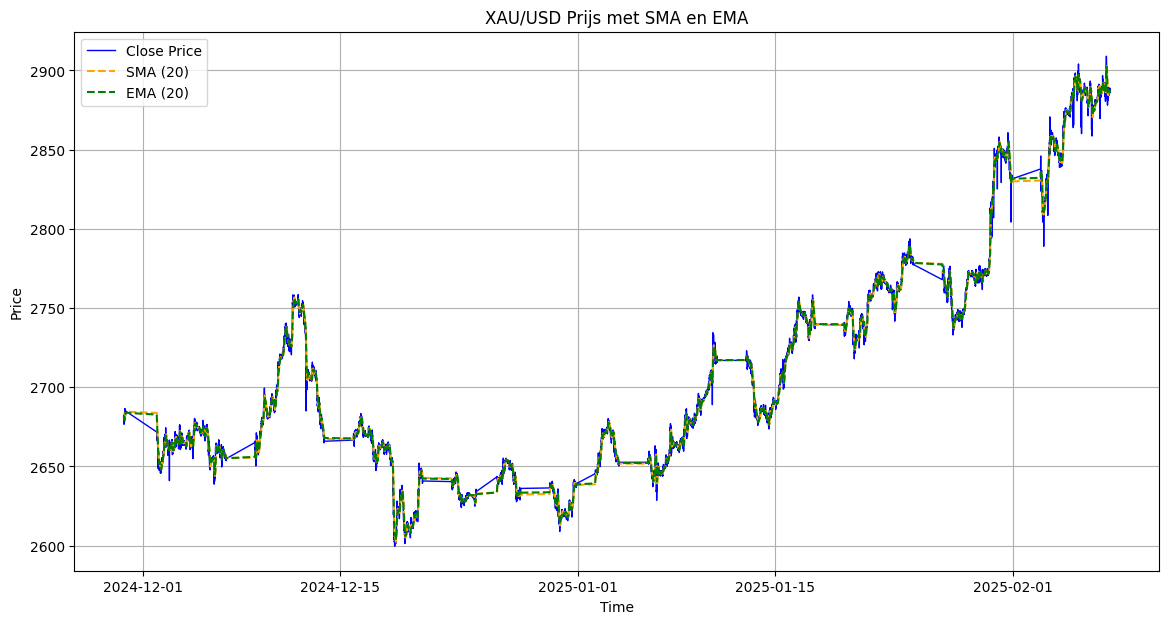

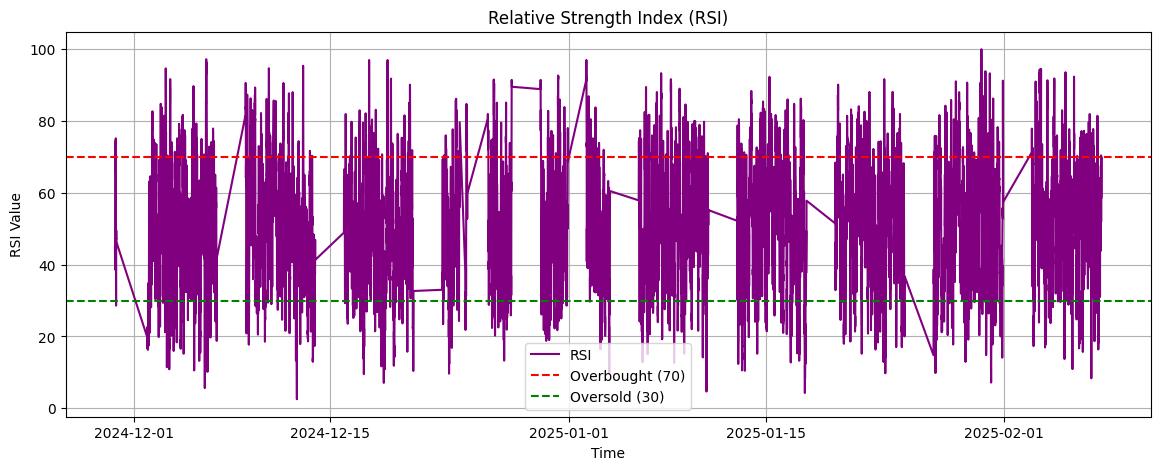

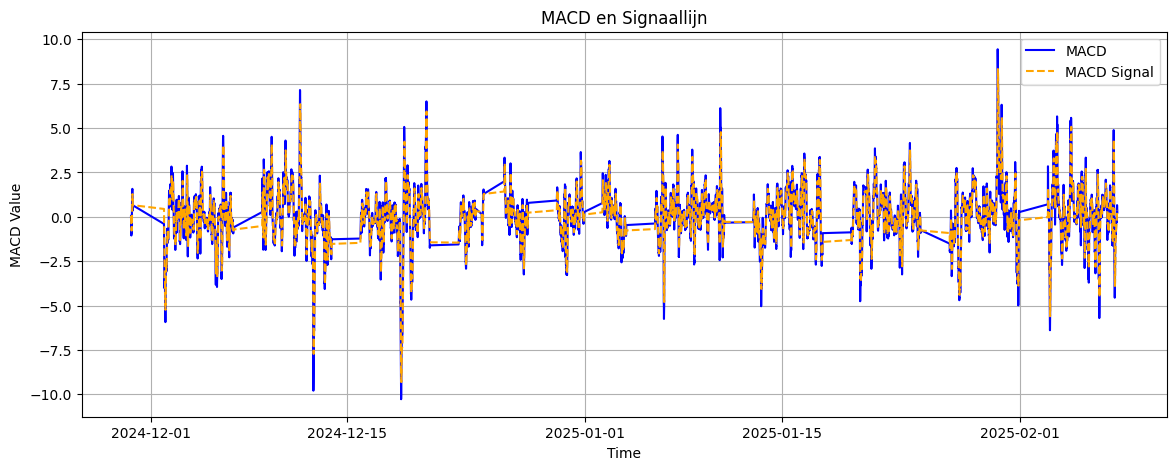

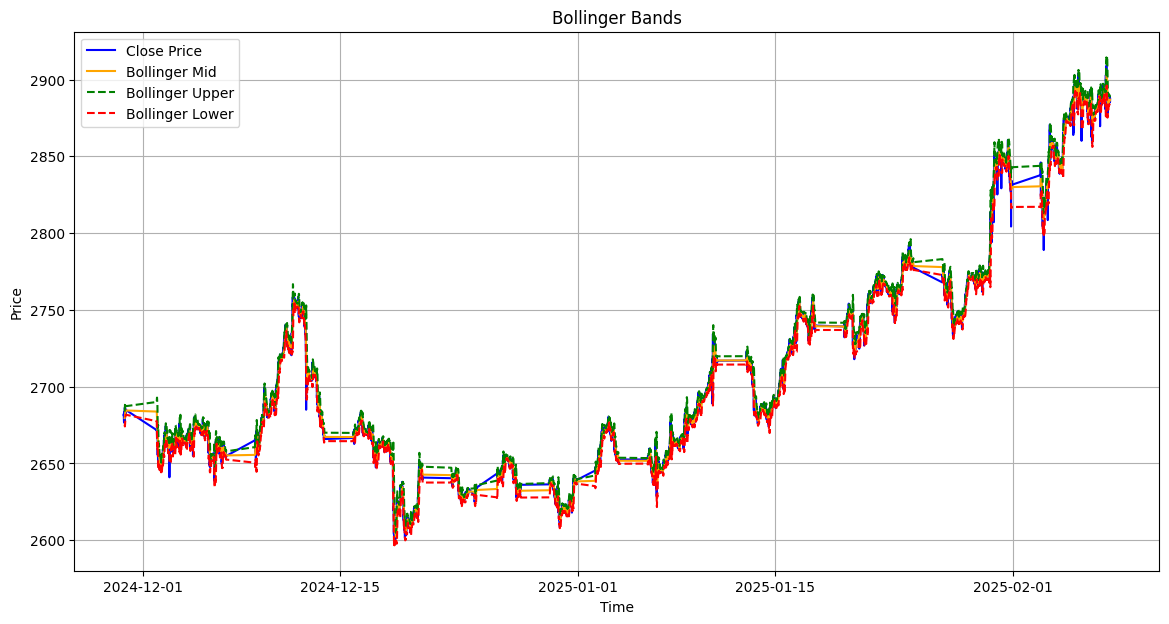

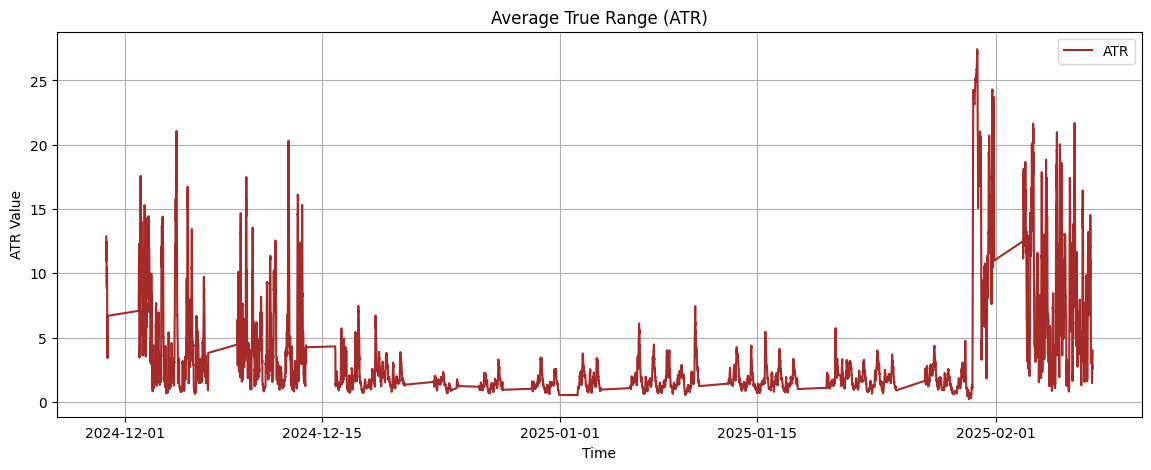

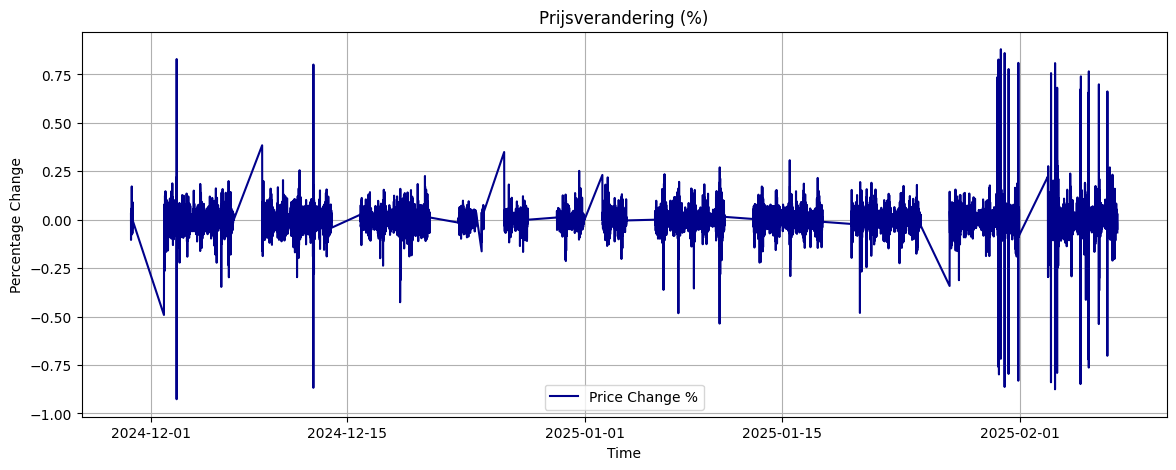

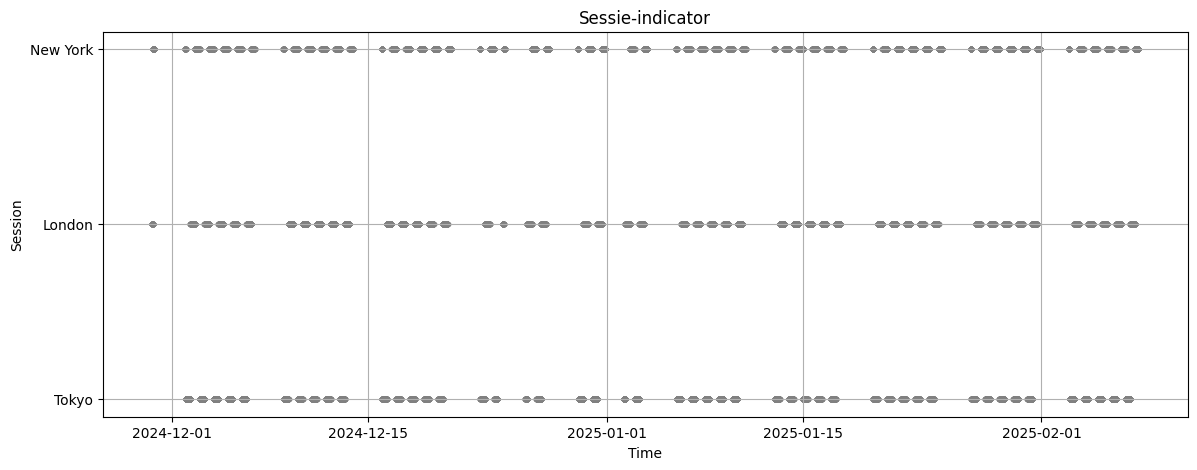

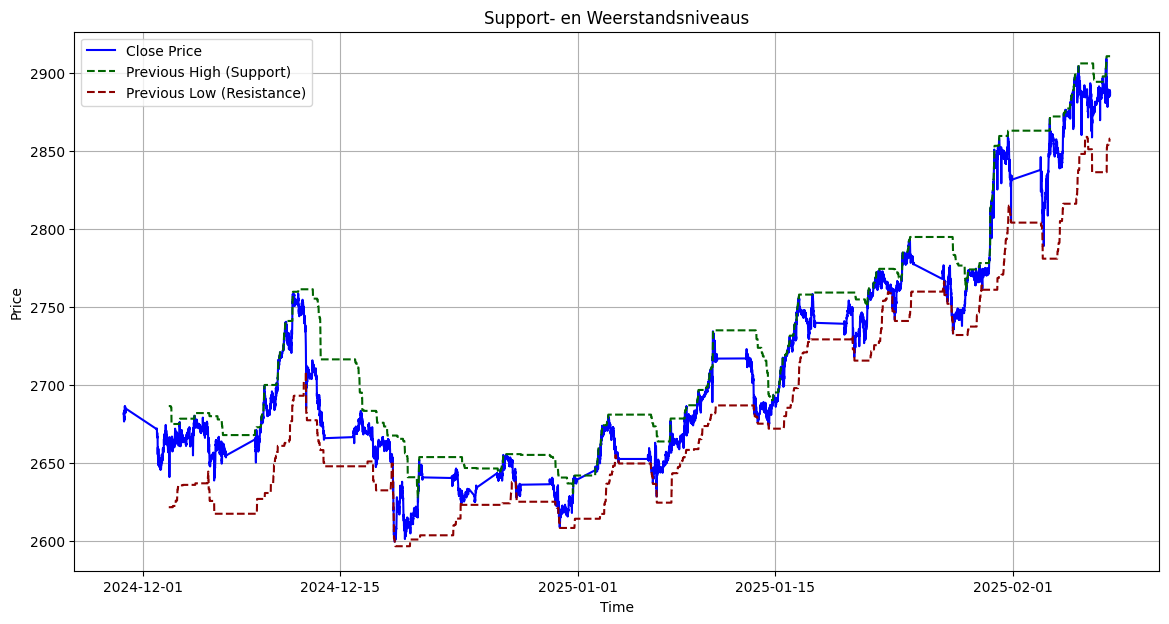

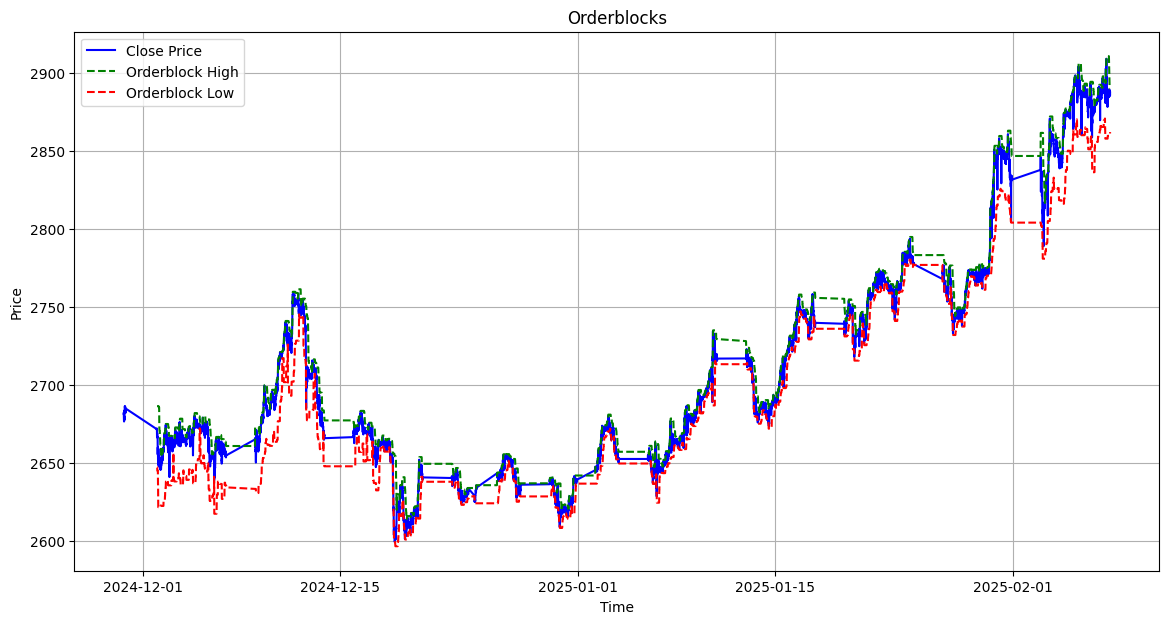

In [92]:
import matplotlib.pyplot as plt

# --- Visualisatie 1: Prijs met SMA en EMA ---
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Close Price', color='blue', linewidth=1)
plt.plot(data.index, data['SMA_20'], label='SMA (20)', color='orange', linestyle='--')
plt.plot(data.index, data['EMA_20'], label='EMA (20)', color='green', linestyle='--')

plt.title('XAU/USD Prijs met SMA en EMA')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# --- Visualisatie 2: RSI ---
plt.figure(figsize=(14, 5))
plt.plot(data.index, data['RSI'], label='RSI', color='purple')

# Lijnen voor overbought en oversold
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')

plt.title('Relative Strength Index (RSI)')
plt.xlabel('Time')
plt.ylabel('RSI Value')
plt.legend()
plt.grid(True)
plt.show()

# --- Visualisatie 3: MACD ---
plt.figure(figsize=(14, 5))
plt.plot(data.index, data['MACD'], label='MACD', color='blue')
plt.plot(data.index, data['MACD_Signal'], label='MACD Signal', color='orange', linestyle='--')

plt.title('MACD en Signaallijn')
plt.xlabel('Time')
plt.ylabel('MACD Value')
plt.legend()
plt.grid(True)
plt.show()

# --- Visualisatie 4: Bollinger Bands ---
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Close Price', color='blue')
plt.plot(data.index, data['BB_Mid'], label='Bollinger Mid', color='orange')
plt.plot(data.index, data['BB_Upper'], label='Bollinger Upper', color='green', linestyle='--')
plt.plot(data.index, data['BB_Lower'], label='Bollinger Lower', color='red', linestyle='--')

plt.title('Bollinger Bands')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# --- Visualisatie 5: ATR ---
plt.figure(figsize=(14, 5))
plt.plot(data.index, data['ATR'], label='ATR', color='brown')

plt.title('Average True Range (ATR)')
plt.xlabel('Time')
plt.ylabel('ATR Value')
plt.legend()
plt.grid(True)
plt.show()

# --- Visualisatie 6: Prijsverandering in % ---
plt.figure(figsize=(14, 5))
plt.plot(data.index, data['Price_Change_%'], label='Price Change %', color='darkblue')

plt.title('Prijsverandering (%)')
plt.xlabel('Time')
plt.ylabel('Percentage Change')
plt.legend()
plt.grid(True)
plt.show()

# --- Visualisatie 7: Sessie-indicator (als histogram) ---
data['Session_numeric'] = data['Session'].map({'Tokyo': 0, 'London': 1, 'New York': 2})
plt.figure(figsize=(14, 5))
plt.scatter(data.index, data['Session_numeric'], c='gray', label='Session (Tokyo=0, London=1, New York=2)', s=10)

plt.title('Sessie-indicator')
plt.xlabel('Time')
plt.ylabel('Session')
plt.yticks([0, 1, 2], ['Tokyo', 'London', 'New York'])
plt.grid(True)
plt.show()

# --- Visualisatie 8: Support- en weerstandsniveaus ---
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Close Price', color='blue')
plt.plot(data.index, data['Prev_High'], label='Previous High (Support)', color='darkgreen', linestyle='--')
plt.plot(data.index, data['Prev_Low'], label='Previous Low (Resistance)', color='darkred', linestyle='--')

plt.title('Support- en Weerstandsniveaus')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# --- Visualisatie 9: Orderblocks ---
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Close Price', color='blue')
plt.plot(data.index, data['Orderblock_High'], label='Orderblock High', color='green', linestyle='--')
plt.plot(data.index, data['Orderblock_Low'], label='Orderblock Low', color='red', linestyle='--')

plt.title('Orderblocks')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [93]:
from sklearn.preprocessing import MinMaxScaler

# Verwijder eventuele rijen met NaN-waarden
data_cleaned = data.dropna()

# Normaliseer de numerieke features
scaler = MinMaxScaler()
# Selecteer de relevante features
scaled_features = scaler.fit_transform(data_cleaned[['Close', 'High', 'Low', 'Open', 'Volume', 
                                                     'SMA_20', 'EMA_20', 'RSI', 'ATR', 
                                                     'Session_numeric', 'Prev_Low', 'Prev_High']])

# Maak een nieuwe DataFrame met de geschaalde waarden
scaled_data = pd.DataFrame(scaled_features, index=data_cleaned.index, columns=['Close', 'High', 'Low', 'Open', 'Volume',
                                                                               'SMA_20', 'EMA_20', 'RSI', 'ATR',
                                                                               'Session_numeric', 'Prev_Low', 'Prev_High'])

print(scaled_data.head())

                              Close      High       Low      Open    Volume  \
Datetime                                                                      
2024-12-02 19:35:00+00:00  0.202650  0.200387  0.208735  0.204699  0.001539   
2024-12-02 19:40:00+00:00  0.202973  0.200064  0.134554  0.205664  0.000683   
2024-12-02 19:45:00+00:00  0.202650  0.201356  0.210340  0.206308  0.000843   
2024-12-02 19:50:00+00:00  0.198772  0.198774  0.206808  0.205987  0.001092   
2024-12-02 19:55:00+00:00  0.197156  0.196515  0.204239  0.202124  0.002394   

                             SMA_20    EMA_20       RSI       ATR  \
Datetime                                                            
2024-12-02 19:35:00+00:00  0.191513  0.191879  0.652311  0.106039   
2024-12-02 19:40:00+00:00  0.191912  0.192305  0.620109  0.165618   
2024-12-02 19:45:00+00:00  0.192476  0.192659  0.599499  0.102889   
2024-12-02 19:50:00+00:00  0.192775  0.192596  0.593609  0.102101   
2024-12-02 19:55:00+00:00  0.193

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Features en doelwaarde voorbereiden voor Random Forest
X_rf = scaled_data.drop(columns=['Close'])  # Gebruik alle andere features behalve 'Close'
y_rf = (scaled_data['Close'].diff() > 0).astype(int).shift(-1).fillna(0).astype(int)  # 1 = prijs omhoog, 0 = prijs omlaag

# Gebruik exact dezelfde train/test-verdeling als LSTM
train_size = X_train.shape[0]  # Gebruik de lengte van X_train uit het LSTM-model
X_train_rf = X_rf.iloc[:train_size].values  # Trainingdata voor RF
X_test_rf = X_rf.iloc[train_size:].values   # Testdata voor RF
y_train_rf = y_rf.iloc[:train_size].values  # Trainingslabels
y_test_rf = y_rf.iloc[train_size:].values   # Testlabels

# Train het Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Voorspellingen maken op de testset
y_pred_rf_final = rf_model.predict(X_test_rf)

In [95]:
# Splits de data in training en test
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (10085, 12)
Test data shape: (2522, 12)


In [96]:
import numpy as np

# Functie om tijdreeksen te maken
def create_sequences(data, sequence_length=50):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i + sequence_length].values)
        y.append(data.iloc[i + sequence_length]['Close'])  # Voorspel de 'Close'-prijs
    return np.array(X), np.array(y)

# Maak tijdreeksen voor training en test
X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

print(f"Train sequences shape: {X_train.shape}")
print(f"Test sequences shape: {X_test.shape}")

Train sequences shape: (10035, 50, 12)
Test sequences shape: (2472, 50, 12)


In [97]:
pip install tensorflow


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [98]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Zorg ervoor dat de sequenties al zijn gemaakt
# X_train, y_train, X_test, y_test zijn vanuit eerdere stappen

# LSTM-model opzetten
model = Sequential([


LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.001)),
Dropout(0.3),
LSTM(64),
Dropout(0.3),
    Dense(1)  # Output-laag voor prijsvoorspelling
])

# Model compileren
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Modeloverzicht tonen
model.summary()

/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 50, 64)         │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,801 (206.25 KB)

 Trainable params: 52,801 (206.25 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Epoch 1/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 0.0233 - val_loss: 0.0070
Epoch 2/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.0054 - val_loss: 0.0080
Epoch 3/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 4/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 5/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 7/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 9.1259e-04 - val_loss: 0.0027
Epoch 8/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 7.4200e-04 - val_loss: 0.0013
Epoch 9/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 6.7600e-04 - val_loss: 6.6233e-04
Epoch 10/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 5.7543e-04 - val_loss: 7.4613e-04
Epoch 11/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 5.1429e-04 - val_loss: 5

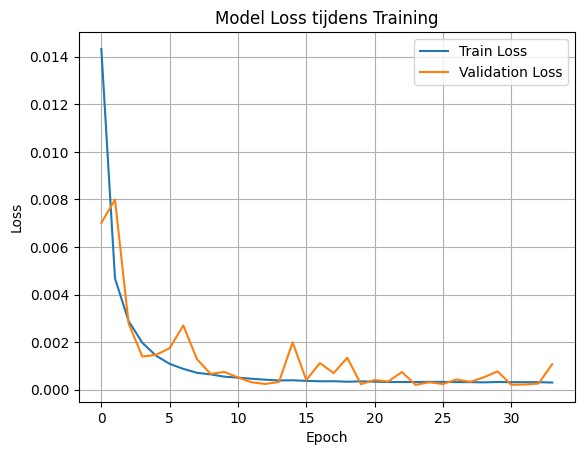

In [100]:
# Train het model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping], verbose=1)

# Plot de training- en validatieverliezen
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss tijdens Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [101]:
# Voorspellingen maken met beide modellen
y_pred_lstm = model.predict(X_test)  # LSTM voorspellingen
y_pred_rf_final = rf_model.predict(X_test_rf)  # Random Forest voorspellingen

# Stap 2: Controleer de vorm van beide voorspellingen
print(f"LSTM voorspellingen vorm: {y_pred_lstm.shape}")
print(f"Random Forest voorspellingen vorm: {y_pred_rf_final.shape}")

# Stap 3: Zorg ervoor dat de voorspellingen dezelfde lengte hebben
min_samples = min(len(y_pred_lstm), len(y_pred_rf_final))
y_pred_lstm = y_pred_lstm[:min_samples]  # Snijd bij indien nodig
y_pred_rf_final = y_pred_rf_final[:min_samples]

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
LSTM voorspellingen vorm: (2472, 1)
Random Forest voorspellingen vorm: (2572,)


In [102]:
# Combineer voorspellingen van LSTM en Random Forest
y_ensemble = (y_pred_lstm.flatten() + y_pred_rf_final) / 2
y_ensemble_final = (y_ensemble > 0.5).astype(int)

# Bereken nauwkeurigheid van het ensemble-model
ensemble_accuracy = (y_ensemble_final == y_test_rf[:len(y_ensemble_final)]).mean() * 100
print(f"Ensemble Voorspellingsnauwkeurigheid: {ensemble_accuracy:.2f}%")

Ensemble Voorspellingsnauwkeurigheid: 49.07%


In [103]:
# Maak voorspellingen met LSTM en Random Forest
y_pred_lstm = model.predict(X_test)  # LSTM voorspellingen
y_pred_rf_final = rf_model.predict(X_test_rf)  # Random Forest voorspellingen

# Combineren van voorspellingen (bijvoorbeeld gemiddelde of stemming)
y_ensemble = (y_pred_lstm.flatten() + y_pred_rf_final) / 2
y_ensemble_final = (y_ensemble > 0.5).astype(int)  # Classificatie: 1 als gemiddelde > 0.5

# Vergelijk ensemble-voorspellingen met werkelijke richtingen
price_diff_actual = np.diff(y_test.flatten())
ensemble_direction = (np.diff(y_ensemble.flatten()) > 0).astype(int)

# Bereken nauwkeurigheid van het ensemble-model
ensemble_accuracy = (ensemble_direction == (price_diff_actual > 0).astype(int)).mean() * 100
print(f"Ensemble Voorspellingsnauwkeurigheid: {ensemble_accuracy:.2f}%")

16/78 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


ValueError: operands could not be broadcast together with shapes (2472,) (2572,) 

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


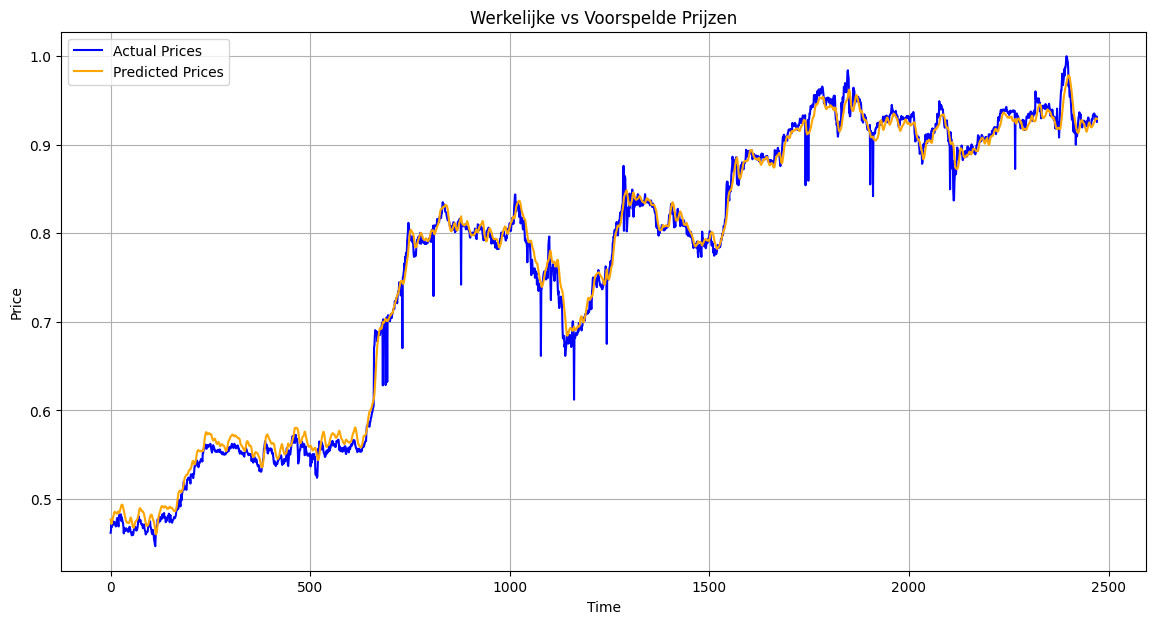

In [106]:
# Voorspellingen maken op de testset
y_pred = model.predict(X_test)

# Vergelijk de voorspellingen met de werkelijke waarden
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='orange')
plt.title('Werkelijke vs Voorspelde Prijzen')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

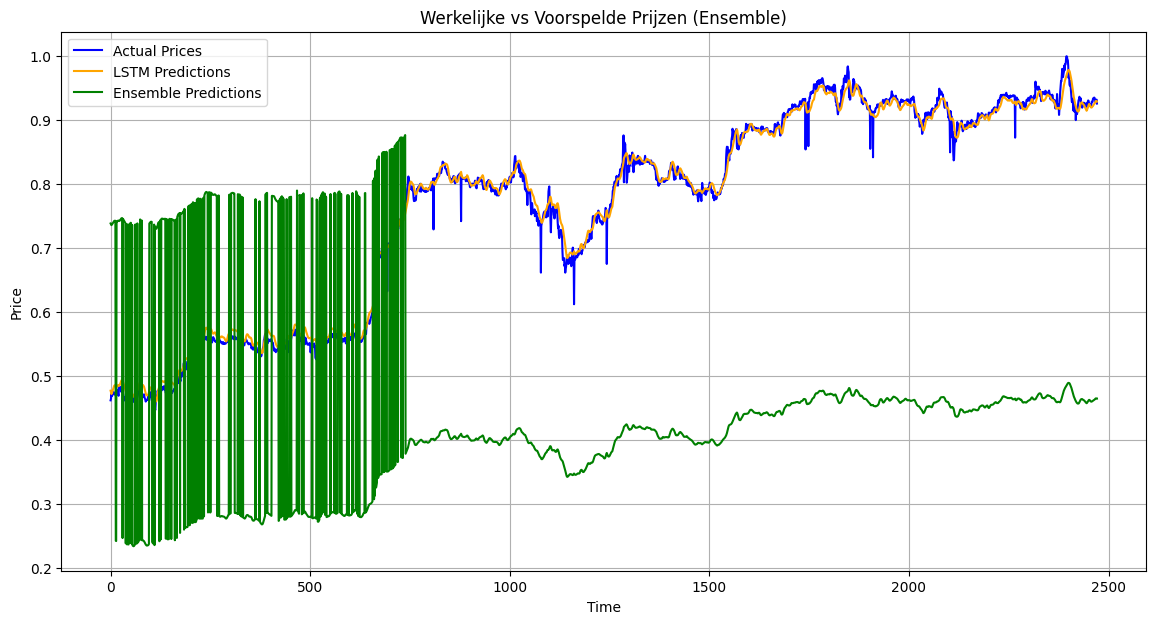

In [104]:
# Plot de werkelijke prijzen, LSTM-voorspellingen en ensemble-voorspellingen
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(y_pred_lstm, label='LSTM Predictions', color='orange')
plt.plot(y_ensemble, label='Ensemble Predictions', color='green')
plt.title('Werkelijke vs Voorspelde Prijzen (Ensemble)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [105]:
# Classificatiebenadering: vergelijk voorspelde richting met werkelijke richting
price_diff_actual = np.diff(y_test)
price_diff_pred = np.diff(y_pred.flatten())

# Label als 1 (omhoog) of 0 (omlaag)
actual_direction = (price_diff_actual > 0).astype(int)
pred_direction = (price_diff_pred > 0).astype(int)

# Bereken de nauwkeurigheid
accuracy = (actual_direction == pred_direction).mean() * 100
print(f"Voorspellingsnauwkeurigheid: {accuracy:.2f}%")

ValueError: operands could not be broadcast together with shapes (2471,) (2470,) 